In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import random
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,precision_recall_curve

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"
seed_torch(2023)
fontdict = {'family' : 'Times New Roman', 'size' : 10}
plt.rc('font',family='Times New Roman')

In [27]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.filter_ages(ALL_data,18)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')
# ALL_data = ECGHandle.remove_duplicated(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data_buffer,0.2,Range_max=15,pair_num=1)
# test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)



            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal            QC         
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


            orginal   filtered department 
   nums      69819           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15

In [28]:
supplement_diagnose = pd.read_csv('./补充诊断.csv',encoding='utf-8-sig')
supplement_diagnose['ID'] = supplement_diagnose['ID'].astype(str)
# 使用groupby方法按照ID分组，然后使用agg方法将data列拼接在一起
supplement_diagnose = supplement_diagnose.groupby('ID')['住院所有诊断'].agg(lambda x: ','.join(x.astype(str))).reset_index()
# 使用str.contains方法筛选data列中包含‘高血压’的行
filtered_df = supplement_diagnose[supplement_diagnose['住院所有诊断'].str.contains('高血压')]
# 将筛选后的ID列转换为list
id_list = filtered_df['ID'].astype(str).tolist()

In [17]:
print("{:^10} {:^10} {:^20}".format('test','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(test_df[(test_df['label']==1)]),len(test_df[(test_df['label']==0)])))

reset_index = test_df[[True if i in id_list else False for i in test_df['ID']]].index
test_df.loc[reset_index,'label'] = 1
print("{:^20} {:^5}".format("reset num:",len(reset_index)))

print("{:^10} {:^10} {:^20}".format('test','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(test_df[(test_df['label']==1)]),len(test_df[(test_df['label']==0)])))

   test       HTN             NHTN        
   nums       340             261         
     reset num:       358 
   test       HTN             NHTN        
   nums       409             192         


In [62]:
output_list = [
                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_0.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_1.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_2.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_3.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_4.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_0.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_1.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_2.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_3.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_4.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor1_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor2_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor3_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor4_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor5_withou_age_Gender.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_0.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_1.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_2.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_3.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_4.csv',
               ]
# '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_0.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_1.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_2.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_3.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_4.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_0.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_1.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_2.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_3.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_4.csv',
y_trues_list = []
y_outs_list = []
y_pred_list = []
for i in range(len(output_list)):#
    output = pd.read_csv(output_list[i])
    if 'ID' in output.columns:
        print("{:^10} {:^10} {:^20}".format('output','HTN','NHTN'))
        print("{:^10} {:^10} {:^20}".format('nums',len(output[(output['target']==1)]),len(output[(output['target']==0)])))

        reset_index = output[[True if i in id_list else False for i in (output['ID']).astype(str)]].index
        output.loc[reset_index,'target'] = 1
        print("{:^10} {:^10} {:^20}".format('output','HTN','NHTN'))
        print("{:^10} {:^10} {:^20}".format('nums',len(output[(output['target']==1)]),len(output[(output['target']==0)])))
        print("{:^20} {:^5}".format("reset num:",len(output)))
    y_trues_list.append(output['target'])
    y_outs_list.append(output['out1'])


  output      HTN             NHTN        
   nums       271             263         
  output      HTN             NHTN        
   nums       334             200         
     reset num:       534 
  output      HTN             NHTN        
   nums       271             263         
  output      HTN             NHTN        
   nums       334             200         
     reset num:       534 
  output      HTN             NHTN        
   nums       271             263         
  output      HTN             NHTN        
   nums       334             200         
     reset num:       534 
  output      HTN             NHTN        
   nums       271             263         
  output      HTN             NHTN        
   nums       334             200         
     reset num:       534 
  output      HTN             NHTN        
   nums       271             263         
  output      HTN             NHTN        
   nums       334             200         
     reset num:       534 
  out

In [63]:

# 定义一个函数，根据给定的阈值将概率预测转换为二进制标签
def binarize(y_pred, threshold):
    return np.where(y_pred >= threshold, 1, 0)

# 定义一个函数，根据给定的混淆矩阵计算出各种指标
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    npv = tn / (tn + fn)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    f1 = 2 * tp / (2 * tp + fp + fn)
    return sensitivity, specificity, precision, npv, accuracy, f1
for modelgorup in range(0,len(y_trues_list),5):
    
    # 创建一个空的dataframe，用于存储结果
    df = pd.DataFrame(columns=['Threshold', 'Model', 'Sensitivity', 'Specificity', 'Precision', 'NPV', 'Accuracy', 'F1-score'])


    y_outs = np.array(y_outs_list[modelgorup:modelgorup+5])
    y_labels = np.array(y_trues_list[modelgorup:modelgorup+5])
    thresholds = [0.5]
    # 对于每个阈值和每个模型，计算并保存指标
    for t in thresholds:
        for i in range(5):
            # 选择第i个模型的输出
            y_pred_i = y_outs[i]
            # 将输出二值化
            y_pred_bin = binarize(y_pred_i, t)
            # 计算混淆矩阵
            cm = confusion_matrix(y_labels[i], y_pred_bin)
            # 计算指标
            sensitivity, specificity, precision, npv, accuracy, f1 = calculate_metrics(cm)
            # 将结果追加到dataframe中
            df = df.append({'Threshold': t,
                            'Model': i + 1,
                            'Sensitivity': sensitivity,
                            'Specificity': specificity,
                            'Precision': precision,
                            'NPV': npv,
                            'Accuracy': accuracy,
                            'F1-score': f1}, ignore_index=True)
    
    # 对于每个阈值，计算各种指标的平均值和方差，并将其转换为'Mean±（SE）'的形式
    df_mean = df.groupby('Threshold').mean() *100.
    df_std = df.groupby('Threshold').std()
    df_se = ((1.96 * df_std) / np.sqrt(5)) *100. # 标准误差等于标准差除以样本数的平方根

    df_std = df_std*100.
    df_mean = df_mean.applymap(lambda x: '{:.3f}'.format(x))
    df_se = df_se.applymap(lambda x: '{:.3f}'.format(x))
    df_std = df_std.applymap(lambda x: '{:.3f}'.format(x))

    df_result = df_mean.astype(str) + '±' + df_std.astype(str)
    print(df_result.to_string())


                     Model   Sensitivity   Specificity     Precision           NPV      Accuracy      F1-score
Threshold                                                                                                     
0.5        300.000±158.114  69.820±4.069  89.600±4.866  92.017±2.974  64.122±2.016  77.228±1.151  79.274±1.696
                     Model   Sensitivity    Specificity     Precision           NPV      Accuracy      F1-score
Threshold                                                                                                      
0.5        300.000±158.114  83.472±9.761  52.292±17.707  79.443±4.407  62.563±8.425  73.511±1.185  80.923±2.489
                     Model  Sensitivity   Specificity     Precision           NPV      Accuracy      F1-score
Threshold                                                                                                    
0.5        300.000±158.114  5.904±5.245  98.859±0.760  81.879±9.174  50.517±1.299  51.685±2.384  10.659±8.640
 

In [57]:
plt.rc('font',family='Times New Roman')
plt.rcParams.update ( {'font.size': 11}) 

MMLNetAverage ROC (AUC=0.91)
MMLNet95% confidence interval: [0.893 - 0.930]
ResNet50Average ROC (AUC=0.74)
ResNet5095% confidence interval: [0.698 - 0.777]
RandomForestAverage ROC (AUC=0.73)
RandomForest95% confidence interval: [0.710 - 0.751]
ECGNETAverage ROC (AUC=0.85)
ECGNET95% confidence interval: [0.779 - 0.930]


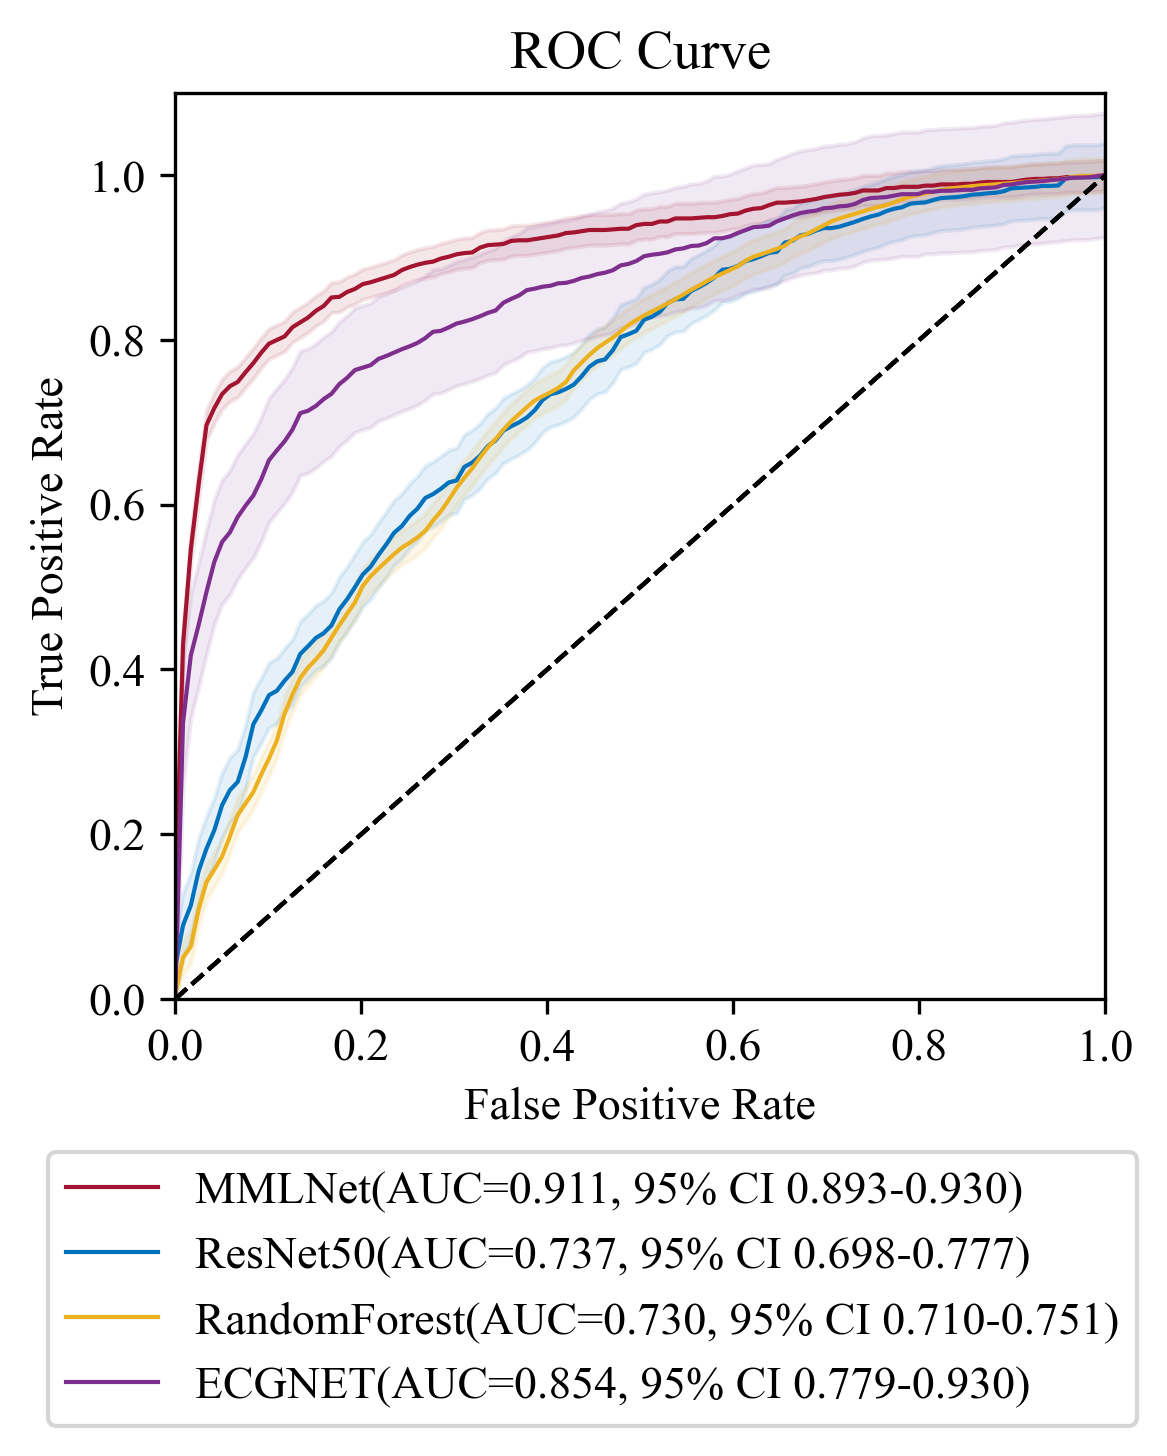

In [58]:
# Plot average ROC curve and confidence interval
fig,ax = plt.subplots(1,1,figsize = (4,4),dpi = 300)

colors_list = ['#A2142F','#0072BD','#EDB120','#7E2F8E']
plot_label_list =['MMLNet',"ResNet50",'RandomForest','ECGNET'] 

for modelgorup in range(0,len(y_trues_list),5):
    y_outs = np.array(y_outs_list[modelgorup:modelgorup+5])
    y_labels = np.array(y_trues_list[modelgorup:modelgorup+5])
    
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = np.zeros(len(y_labels))
    mean_fpr = np.linspace(0, 1, 120)
    tprs = []
    aucs = []

    for i in range(len(y_labels)):
        fpr[i], tpr[i], thresholds[i]  = roc_curve(y_labels[i], y_outs[i])
        tprs.append(np.interp(mean_fpr,fpr[i], tpr[i]))#插值
        aucs.append(auc(fpr[i], tpr[i]))
        
    mean_tpr = np.mean(tprs,axis=0)
    mean_auc = auc(mean_fpr , mean_tpr)

    # Compute confidence interval
    std_auc = np.std(aucs)
    ci_lower = mean_auc - 1.96 * std_auc
    ci_upper = mean_auc + 1.96 * std_auc

    
    ax.plot(mean_fpr , mean_tpr ,
            label=plot_label_list[modelgorup//5]+'(AUC=%0.3f, 95%% CI %0.3f-%0.3f)' % (mean_auc,ci_lower , ci_upper),
            color=colors_list[modelgorup//5], linewidth=1)

    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_auc * 1.96,
                                np.zeros_like(mean_tpr)),#确保不会小于0 
                    mean_tpr + std_auc * 1.96,
                    color=colors_list[modelgorup//5], alpha=0.1,
                   )# label=plot_label_list[modelgorup//5]+' CI (%0.3f-%0.3f)'  % (ci_lower , ci_upper)

    ax.plot([0 , 1], [0 , 1], 'k--', linewidth=1)
    ax.set_xlim([0. , 1])
    ax.set_ylim([0. , 1.1])

    print(plot_label_list[modelgorup//5]+"Average ROC (AUC=%0.2f)" % mean_auc)
    print(plot_label_list[modelgorup//5]+"95%% confidence interval: [%0.3f - %0.3f]" % (ci_lower , ci_upper))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# ax.legend(loc="lower right")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles,loc='lower left', bbox_to_anchor=(0, -0.25), bbox_transform=plt.gcf().transFigure)

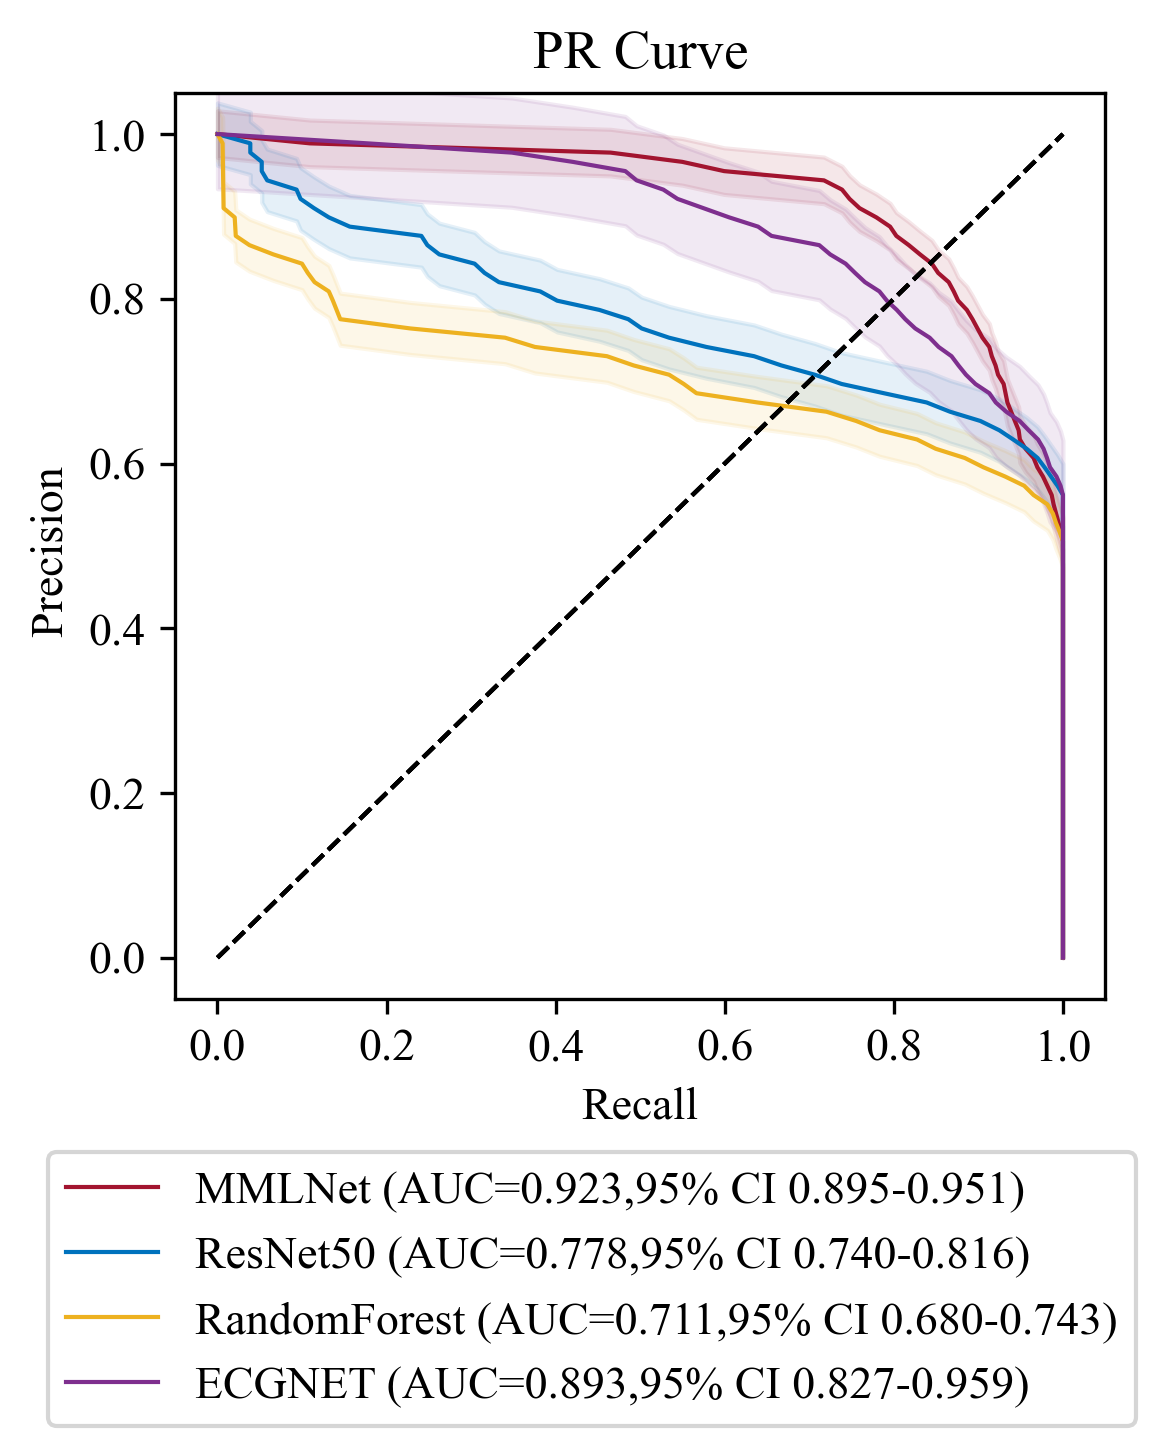

In [59]:
fig,ax = plt.subplots(1,1,figsize = (4,4),dpi = 300)
for modelgorup in range(0,len(y_trues_list),5):
    y_outs = np.array(y_outs_list[modelgorup:modelgorup+5])
    y_labels = np.array(y_trues_list[modelgorup:modelgorup+5])

    precision = dict()
    recall = dict()
    thresholds = dict()
    roc_auc = np.zeros(len(y_labels))
    mean_precision = np.linspace(0, 1, 90)
    recalls = []
    prs = []

    for i in range(len(y_labels)):
        precision[i], recall[i], thresholds[i]  = precision_recall_curve(y_labels[i], y_outs[i])
        recalls.append(np.interp(mean_precision,precision[i], recall[i]))#插值
        prs.append(auc( recall[i],precision[i],))
        
    mean_recall = np.mean(recalls,axis=0)
    mean_prs = auc(mean_recall,mean_precision )

    # Compute confidence interval
    std_prs = np.std(prs)
    ci_lower = mean_prs - 1.96 * std_prs
    ci_upper = mean_prs + 1.96 * std_prs

    # Plot average ROC curve and confidence interval
   
    ax.plot(mean_recall ,mean_precision , 
            label=plot_label_list[modelgorup//5]+' (AUC=%0.3f,95%% CI %0.3f-%0.3f)' % (mean_prs,ci_lower , ci_upper),
            color=colors_list[modelgorup//5], linewidth=1)

    ax.fill_between(mean_recall,
                    np.maximum(mean_precision - std_prs * 1.96,
                                np.zeros_like(mean_precision)),#确保不会小于0 
                    mean_precision + std_prs * 1.96,
                    color=colors_list[modelgorup//5], alpha=0.1,
                    )#label=plot_label_list[modelgorup//5]+' 95%% CI (%0.3f-%0.3f)'  % (ci_lower , ci_upper)

    ax.plot([0 , 1], [0 , 1], 'k--', linewidth=1)
    ax.set_xlim([-0.05 , 1.05])
    ax.set_ylim([-.05 , 1.05])
    
plt.xlabel('Recall')
plt.ylabel('Precision ')
plt.title('PR Curve')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles,loc='lower left', bbox_to_anchor=(0, -0.25), bbox_transform=plt.gcf().transFigure)